# Visualising ERI index compression using lower-triungular matrix indices

In [1]:
import numpy as np
from plot_utils import plot2D

> tril_indices test passed!


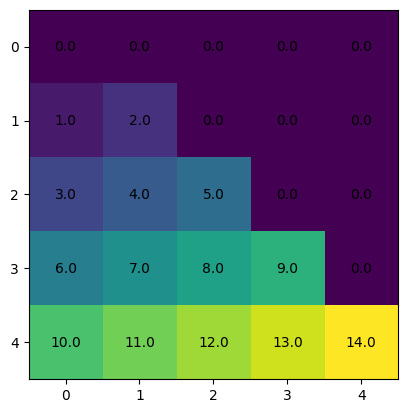

In [2]:
N = 5

original_tensor = np.zeros((N, N))

# populate tensor with tril_indices
for c, (i, j) in enumerate(zip(*np.tril_indices(N))):
    original_tensor[i, j] = c # c = 0,1,2,3,... (enumerated)

# check values with forloops
for i in range(N):
    for j in range(i+1):
        assert original_tensor[i, j] == i*(i+1)/2+j # c = i*(i+1)/2+j (compressed index)
print('> tril_indices test passed!')
        
plot2D(original_tensor, N, show_values=True)

Extract i, j from c

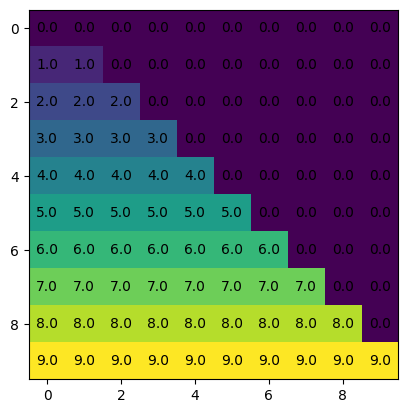

In [3]:
N = 10

# plot i computed from c
dist_tensor = np.zeros((N, N))
for c, (i, j) in enumerate(zip(*np.tril_indices(N))):
    dist_tensor[i, j] = np.floor((np.sqrt(1 + 8*c) - 1)/2)

plot2D(dist_tensor, N, show_values=(N<=12))

Problem is np.floor((np.sqrt(1 + 8*c) - 1)/2) overflows in 8*c! Let's visualise that with int8 (but we will see this happening with int16, int32, etc)

c is fine in uint8
N is fine in uint8


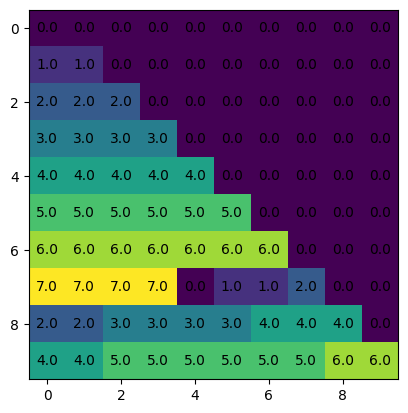

In [4]:
# ------------------------------- #
# ignore Python casting warnings
import warnings
warnings.filterwarnings('ignore')
# ------------------------------- #

N = 10

max_c = 0

# plot i computed from c
dist_tensor = np.zeros((N, N))
for c, (i, j) in enumerate(zip(*np.tril_indices(N))):
    dist_tensor[i, j] = np.floor((np.sqrt(1 + np.array(8*c, dtype=np.uint8)) - 1)/2)
    if c > max_c: # could have just taken the last c :-)
        max_c = c

assert max_c == np.uint8(max_c)
print('c is fine in uint8')
assert N == np.uint8(N)
print('N is fine in uint8')

plot2D(dist_tensor, N, show_values=(N<=12))

# ------------------------------- #
# enable Python casting warnings
warnings.resetwarnings()
# ------------------------------- #

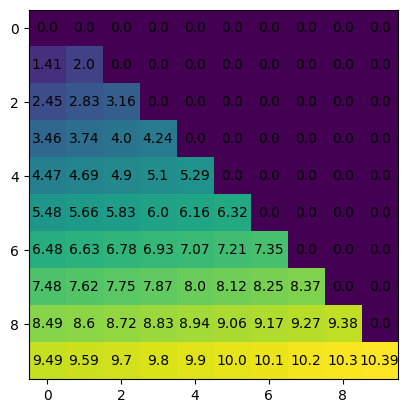

In [5]:
N = 10

# plot distance to top-left corner
dist_tensor = np.zeros((N, N))
for c, (i, j) in enumerate(zip(*np.tril_indices(N))):
    dist_tensor[i, j] = np.around(np.sqrt(2)*np.sqrt(c), decimals=2)

plot2D(dist_tensor, N, show_values=(N<=12))

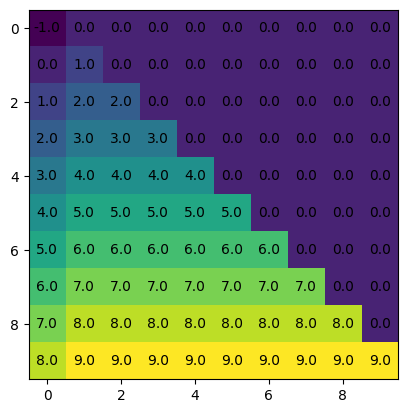

In [6]:
N = 10

# plot distance to top-left corner
dist_tensor = np.zeros((N, N))
for c, (i, j) in enumerate(zip(*np.tril_indices(N))):
    dist_tensor[i, j] = np.round(np.sqrt(2)*np.sqrt(c)-1)

plot2D(dist_tensor, N, show_values=(N<=12))

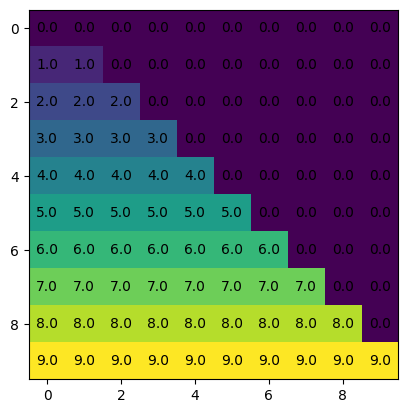

In [7]:
N = 10

# plot distance to top-left corner
dist_tensor = np.zeros((N, N))
for c, (i, j) in enumerate(zip(*np.tril_indices(N))):
    dist_tensor[i, j] = np.round(np.sqrt(2)*np.sqrt(c+1)-1)

plot2D(dist_tensor, N, show_values=(N<=12))

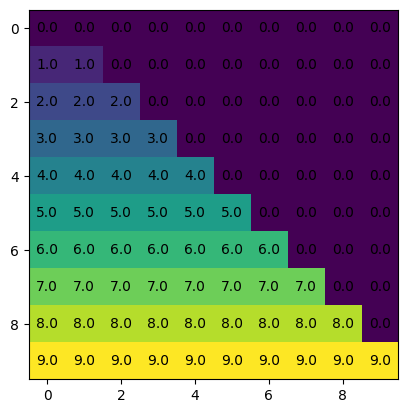

In [8]:
N = 10

# plot distance to top-left corner
dist_tensor = np.zeros((N, N))
for c, (i, j) in enumerate(zip(*np.tril_indices(N))):
    my_i = np.round(np.sqrt(2)*np.sqrt(c))
    my_i = np.where(my_i*(my_i+1)/2 == c, my_i, my_i-1)
    dist_tensor[i, j] = my_i
    

plot2D(dist_tensor, N, show_values=(N<=12))

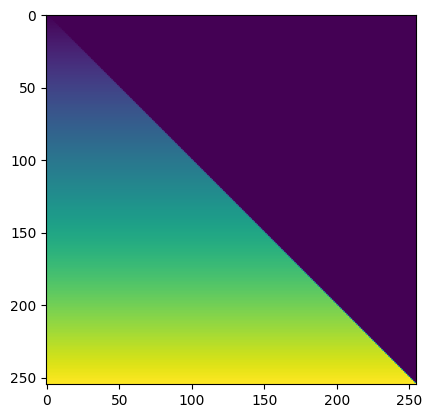

In [9]:
N = 255

# plot distance to top-left corner
dist_tensor = np.zeros((N, N))
for c, (i, j) in enumerate(zip(*np.tril_indices(N))):
    my_i = np.round(np.sqrt(2)*np.sqrt(c)).astype(np.uint8)
    my_i = np.where(my_i**2 - c == c - my_i, my_i, my_i-1)
    my_j = (((c - my_i) - (my_i**2 - c))//2).astype(np.uint32)
    assert my_i == i, (my_i, i)
    assert my_j == j, (my_j, j)
    dist_tensor[i, j] = my_i
    

plot2D(dist_tensor, N, show_values=(N<=12))

/tmp/ipykernel_2858194/1492026618.py:9: RuntimeWarning: divide by zero encountered in remainder
  i = i + np.where(i%2==0, val%(i+1)==0, val%i==0).astype(np.uint32) - 1


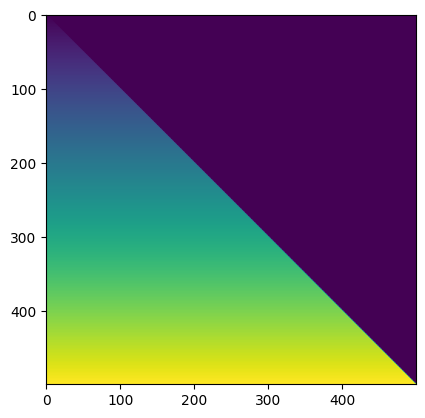

In [10]:
# testing

N = 500

def get_i_j(val):
    # we also need it to work for val.dtype == uint64, hence we do not cast val directly
    sqrt_val = np.sqrt(val.astype(np.float32)).astype(np.float32)
    i = np.round(np.sqrt(2)*sqrt_val).astype(np.uint32)
    i = i + np.where(i%2==0, val%(i+1)==0, val%i==0).astype(np.uint32) - 1
    j = np.where(i%2==0, (val%(i+1)).astype(np.uint32), ((val-(i-1)/2-1)%(i+1)).astype(np.uint32))
    return i, j

# plot distance to top-left corner
i_tensor = np.zeros((N, N))
j_tensor = np.zeros((N, N))
for c, (i, j) in enumerate(zip(*np.tril_indices(N))):
    my_i, my_j = get_i_j(np.array(c))
    i_tensor[i, j] = my_i
    j_tensor[i, j] = my_j
    assert my_i == i, (my_i, i)
    assert my_j == j, (my_j, j)
    

plot2D(i_tensor, N, show_values=(N<=12))
# plot2D(j_tensor, N, show_values=(N<=12))

In [11]:
import pyscf
from icecream import ic

natm = 1

skip_dense = True

def get_i_j(val, precision='x32'):
    # we need it to work for val.dtype == uint64 when called with the main index
    if precision == 'x32':
        sqrt_val = np.round(np.sqrt(2)*np.sqrt(val.astype(np.float32))).astype(np.uint32)
    else:
        sqrt_val = np.round(np.sqrt(2)*np.sqrt(val.astype(np.float64))).astype(np.uint32)
    i = sqrt_val + np.where(sqrt_val%2==0, val%(sqrt_val+1)==0, val%sqrt_val==0).astype(np.uint32) - 1
    ic(i)
    j = np.where(i%2==0, (val%(i+1)).astype(np.uint32), ((val-(i-1)/2-1)%(i+1)).astype(np.uint32))
    ic(j)
    return i, j

mol = pyscf.gto.Mole(atom="".join(f"C 0 {1.54*j} {1.54*i};" for i in range(natm) for j in range(natm)))
mol.build()
N = mol.nao_nr()
ic(N)

if not skip_dense:
    dense_ERI = mol.intor("int2e_sph", aosym="s1")
distinct_ERI = mol.intor("int2e_sph", aosym="s8")

nonzero_indices = np.nonzero(distinct_ERI)[0] # int64 by default
nonzero_distinct_ERI_int64ind = distinct_ERI[nonzero_indices]
ic(nonzero_indices.dtype)
nonzero_indices = nonzero_indices.astype(np.uint64)
nonzero_distinct_ERI_uint64ind = distinct_ERI[nonzero_indices]
ic(nonzero_indices.dtype)

assert np.equal(nonzero_distinct_ERI_int64ind, nonzero_distinct_ERI_uint64ind).all()
ic('Accessing values with uint64 vs int64 is fine')

ic(nonzero_indices.shape)

last_index = nonzero_indices.shape[0]

# test_index_casting = True
# for i in range(last_index-10, last_index):
#     if nonzero_indices[i] != nonzero_indices[i].astype(np.uint32):
#         test_index_casting = False
# if test_index_casting:
#     ic('Casting indices to uint32 is fine')
# else:
#     ic('Casting indices to uint32 is NOT FINE')

nonzero_indices_2d = np.stack(get_i_j(nonzero_indices, precision='x64'), axis=1) # ijkl x64 -> ij,kl x32 -- shape=(?, 2)
assert np.equal(nonzero_indices_2d, nonzero_indices_2d.astype(np.uint32)).all()
nonzero_indices_2d = nonzero_indices_2d.astype(np.uint32)
ic(np.max(np.diff(nonzero_indices_2d, axis=0)))
a = nonzero_indices
b = (nonzero_indices_2d[:,0].astype(np.uint64)*(nonzero_indices_2d[:,0].astype(np.uint64)+1)/2+nonzero_indices_2d[:,1].astype(np.uint64)).astype(np.uint64)
assert np.equal(a, b).all(), (a, b, np.nonzero(np.abs(a-b)))

nonzero_indices_4d = np.concatenate(get_i_j(nonzero_indices_2d), axis=1) # ij,kl x32 -> i,j,k,l x32 -- shape=(?, 2)
nonzero_indices_4d = nonzero_indices_4d.astype(np.uint32)
ic(np.max(np.diff(nonzero_indices_4d, axis=0)))

ic(nonzero_indices_4d.shape)
a = nonzero_indices
b_ij = (nonzero_indices_4d[:,0].astype(np.uint64)*(nonzero_indices_4d[:,0].astype(np.uint64)+1)/2+nonzero_indices_4d[:,2].astype(np.uint64)).astype(np.uint64)
b_kl = (nonzero_indices_4d[:,1].astype(np.uint64)*(nonzero_indices_4d[:,1].astype(np.uint64)+1)/2+nonzero_indices_4d[:,3].astype(np.uint64)).astype(np.uint64)
b = (b_ij*(b_ij+1)/2+b_kl).astype(np.uint64)
assert np.equal(a, b).all(), (a, b, np.nonzero(np.abs(a-b)), np.nonzero(np.abs(a-b))[0].shape)

# for val in range(last_index-10, last_index):
# # for val in range(nonzero_indices.shape[0]):
#     # ic(val, type(val))
#     index = nonzero_indices[val] #.astype(np.uint32)
#     # ic(index.dtype)
#     ij, kl = get_i_j(index, precision='x64')

#     # check reconstruct
#     # ic((index, index, ij, kl))
#     rec_index = ij.astype(np.uint64)*(ij.astype(np.uint64)+1)//2 + kl.astype(np.uint64)
#     assert index == rec_index, (index, rec_index)
    
#     i, j= get_i_j(ij)
#     k, l = get_i_j(kl)

#     # ic(i, j, k, l)
#     # ic(i.dtype, j.dtype, k.dtype, l.dtype)
#     if not skip_dense:
#         assert np.allclose(nonzero_distinct_ERI_uint64ind[val], dense_ERI[i, j, k, l]), (nonzero_distinct_ERI_uint64ind[val], dense_ERI[i, j, k, l])


        
ic('Reconstructing indices is fine')


/localdata/mihaip/workspace/envs/poplar_sdk-ubuntu_20_04-3.2.0+1277-7cd8ade3cd/3.2.0+1277_poptorch/lib/python3.8/site-packages/numpy/ctypeslib.py:137: DeprecationWarning: 

  `numpy.distutils` is deprecated since NumPy 1.23.0, as a result
  of the deprecation of `distutils` itself. It will be removed for
  Python >= 3.12. For older Python versions it will remain present.
  It is recommended to use `setuptools < 60.0` for those Python versions.
  For more details, see:
    https://numpy.org/devdocs/reference/distutils_status_migration.html 


  from numpy.distutils.misc_util import get_shared_lib_extension
ic| N: 5
ic| nonzero_indices.dtype: dtype('int64')
ic| nonzero_indices.dtype: dtype('uint64')
ic| 'Accessing values with uint64 vs int64 is fine'
ic| nonzero_indices.shape: (33,)
/tmp/ipykernel_2858194/82872427.py:14: RuntimeWarning: divide by zero encountered in remainder
  i = sqrt_val + np.where(sqrt_val%2==0, val%(sqrt_val+1)==0, val%sqrt_val==0).astype(np.uint32) - 1
ic| i: array

'Reconstructing indices is fine'

In [21]:
ic(np.iinfo(np.uint32))
ic(np.iinfo(np.uint64))
ic(np.finfo(np.float32))
ic(np.finfo(np.float64))

max_uint32 = np.zeros(1).astype(np.uint32)-1
ic(max_uint32)

max_uint64 = np.zeros(1).astype(np.uint64)-1
ic(max_uint64)

test32 = max_uint32
ic(test32 == test32.astype(np.float32).astype(np.uint32))

test32_128 = max_uint32//128-1 # 32-7 = 25
ic(test32_128 == test32_128.astype(np.float32).astype(np.uint32))

test_sqrt_32 = np.round(np.sqrt(2)*np.sqrt(test32_128.astype(np.float32)))
test_sqrt_64 = np.round(np.sqrt(2)*np.sqrt(test32_128.astype(np.float64)))
ic(test_sqrt_32 == test_sqrt_64, (test_sqrt_32, test_sqrt_64))

test32_11 = max_uint32//(2**11)-1
ic(test32_11)
test32_12 = max_uint32//(2**12)-1
ic(test32_12)
ic(np.power(test32_11, 0.5))
ic(np.power(test32_12, 0.5))

# # size = test32_11.astype(np.uint64)
# ic(size)
# for N in range(1024, 2048):
#     size = N*N
#     test_sqrt_32 = np.round(np.sqrt(2)*np.sqrt(np.arange(size).astype(np.float32)))
#     test_sqrt_64 = np.round(np.sqrt(2)*np.sqrt(np.arange(size).astype(np.float64)))
#     result = np.equal(test_sqrt_32, test_sqrt_64)
#     ic(test_sqrt_64[test_sqrt_64!=test_sqrt_32])
#     ic(test_sqrt_32[test_sqrt_64!=test_sqrt_32])
#     assert result.all(), result[result==False].shape
#     ic('PASSED '+str(N))

####################

for N in range(3250, 4096):
    size = N*N
    # ic(size)
    # test_sqrt_32 = np.round(np.sqrt(2)*np.sqrt(np.arange(size).astype(np.float32)))
    # test_sqrt_32 = np.where(test_sqrt_32**2 - size == size - test_sqrt_32, test_sqrt_32+1, test_sqrt_32)
    test_sqrt_32 = np.floor((np.sqrt(1 + 8*np.arange(size).astype(np.float32)) - 1)/2)
    test_sqrt_64 = np.floor((np.sqrt(1 + 8*np.arange(size).astype(np.float64)) - 1)/2)
    # test_sqrt_64 = np.round(np.sqrt(2)*np.sqrt(np.arange(size).astype(np.float64)))
    result = np.equal(test_sqrt_32, test_sqrt_64)
    # ic(test_sqrt_64[test_sqrt_64!=test_sqrt_32])
    # ic(test_sqrt_32[test_sqrt_64!=test_sqrt_32])
    assert result.all(), (N, result[result==False].shape)
    # ic('PASSED v2 '+str(N))


ic| np.iinfo(np.uint32): iinfo(min=0, max=4294967295, dtype=uint32)
ic| np.iinfo(np.uint64): iinfo(min=0, max=18446744073709551615, dtype=uint64)
ic| np.finfo(np.float32): finfo(resolution=1e-06, min=-3.4028235e+38, max=3.4028235e+38, dtype=float32)
ic| np.finfo(np.float64): finfo(resolution=1e-15, min=-1.7976931348623157e+308, max=1.7976931348623157e+308, dtype=float64)
ic| max_uint32: array([4294967295], dtype=uint32)
ic| max_uint64: array([18446744073709551615], dtype=uint64)
ic| test32 == test32.astype(np.float32).astype(np.uint32): array([False])
ic| test32_128 == test32_128.astype(np.float32).astype(np.uint32): array([ True])
ic| test_sqrt_32 == test_sqrt_64: array([ True])
    (test_sqrt_32, test_sqrt_64): (array([8192.], dtype=float32), array([8192.]))
ic| test32_11: array([2097150], dtype=uint32)
ic| test32_12: array([1048574], dtype=uint32)
ic| np.power(test32_11, 0.5): array([1448.15399734])
ic| np.power(test32_12, 0.5): array([1023.99902344])


AssertionError: (3259, (1,))